In [1]:
#  STEP 1: Install dependencies
! pip install rasterio tensorflow scikit-learn tqdm

#  STEP 2: Imports
import os
import numpy as np
import rasterio
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import matplotlib.pyplot as plt

#  STEP 3: Load all EVI GeoTIFFs into a 3D array
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Unzip EVI files from Google Drive
import shutil

zip_path = "/content/drive/MyDrive/evi_jan_june_2023.zip"
extract_to = "/content/evi_jan_june_2023"

# Copy zip to /content before unzipping
shutil.copy(zip_path, "/content/evi_jan_june_2023.zip")
!unzip -q /content/evi_jan_june_2023.zip -d /content/evi_jan_june_2023
!ls -R /content/evi_jan_june_2023

#  STEP 3: Load all EVI GeoTIFFs into a 3D array
folder = "/content/evi_jan_june_2023/evi_jan_june_2023"
files = sorted([f for f in os.listdir(folder) if f.endswith('.tif')])
print(files)

# print(files)
# exit()

evi_stack = []

print("Reading EVI images...")

for f in files:
    with rasterio.open(os.path.join(folder, f)) as src:
        data = src.read(1).astype('float32')
        evi_stack.append(data)

print(type(evi_stack[0]))
evi_stack = np.array(evi_stack)  # Shape: [time, height, width]
time, height, width = evi_stack.shape

print(f"Loaded EVI stack with shape: {evi_stack.shape}")

print("EVI shape:", evi_stack.shape)
print("EVI stats:", np.nanmin(evi_stack), np.nanmax(evi_stack))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 20.8 MB/s eta 0:00:00
Mounted at /content/drive
/content/evi_jan_june_2023:
evi_jan_june_2023

/content/evi_jan_june_2023/evi_jan_june_2023:
EVI_01_January_2023_Krishna.tif   EVI_04_April_2023_Krishna.tif
EVI_02_February_2023_Krishna.tif  EVI_05_May_2023_Krishna.tif
EVI_03_March_2023_Krishna.tif	  EVI_06_June_2023_Krishna.tif
['EVI_01_January_2023_Krishna.tif', 'EVI_02_February_2023_Krishna.tif', 'EVI_03_March_2023_Krishna.tif', 'EVI_04_April_2023_Krishna.tif', 'EVI_05_May_2023_Krishna.tif', 'EVI_06_June_2023_Krishna.tif']
Reading EVI images...
<class 'numpy.ndarray'>
Loaded EVI stack with shape: (6, 5308, 5811)
EVI shape: (6, 5308, 5811)
EVI stats: -706.1111 118.519554


In [2]:
evi_stack

for i, layer in enumerate(evi_stack):
    nans = np.isnan(layer).sum()
    print(f"Time step {i}: {nans} NaN values")

total_nans = np.isnan(evi_stack).sum()
print("Total NaN values in EVI stack:", total_nans)

total_pixels = np.prod(evi_stack.shape)
nan_percentage = (total_nans / total_pixels) * 100
print(f"Percentage of NaN values: {nan_percentage:.2f}%")


Time step 0: 21023606 NaN values
Time step 1: 21025563 NaN values
Time step 2: 21023606 NaN values
Time step 3: 21023606 NaN values
Time step 4: 21023606 NaN values
Time step 5: 21023606 NaN values
Total NaN values in EVI stack: 126143593
Percentage of NaN values: 68.16%


(6, 5308, 5811)
Pixels that are NaN in ALL timesteps: 21023606


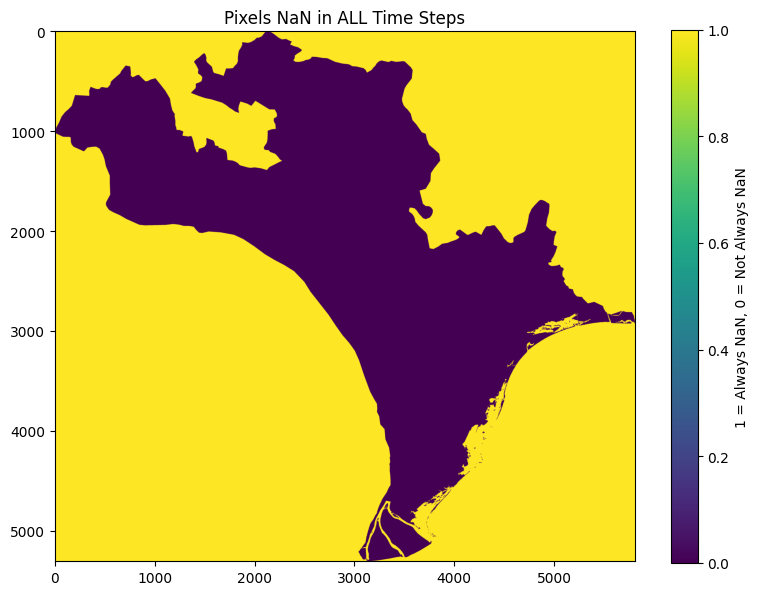

In [3]:
nan_masks = np.isnan(evi_stack)  # (time, height, width)
print(nan_masks.shape)

# --- Check where all time steps are NaN ---
consistent_nan_mask = np.all(nan_masks, axis=0)  # (height, width)
consistent_nan_count = np.sum(consistent_nan_mask)
print("Pixels that are NaN in ALL timesteps:", consistent_nan_count)

# --- Optional: visualize consistent NaN locations ---
plt.figure(figsize=(8, 6))
plt.imshow(consistent_nan_mask, cmap='viridis')
plt.title("Pixels NaN in ALL Time Steps")
plt.colorbar(label="1 = Always NaN, 0 = Not Always NaN")
plt.tight_layout()
plt.show()

In [4]:
evi_scaled = np.empty_like(evi_stack, dtype=np.float32)
mins = np.full((height, width), np.nan, dtype=np.float32)
maxs = np.full((height, width), np.nan, dtype=np.float32)

print("Normalizing pixels with NumPy...")
for i in tqdm(range(height)):
    for j in range(width):
        series = evi_stack[:, i, j]
        if np.isnan(series).any() or np.all(series == 0):
            evi_scaled[:, i, j] = np.nan
            continue
        min_val = np.nanmin(series)
        max_val = np.nanmax(series)
        if max_val - min_val == 0:
            evi_scaled[:, i, j] = np.nan
        else:
            evi_scaled[:, i, j] = (series - min_val) / (max_val - min_val)
            mins[i, j] = min_val
            maxs[i, j] = max_val

Normalizing pixels with NumPy...


100%|██████████| 5308/5308 [07:00<00:00, 12.63it/s]


In [5]:
import os
import numpy as np
import rasterio
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import matplotlib.pyplot as plt



normalized=True
seq_length = 5  # Use 5 months to predict the 6th
X_all = []
y_all = []
coords_all = []
# valid_mask = np.ones((height, width), dtype=bool)
# for t in range(time):
#     valid_mask = valid_mask & ~np.isnan(evi_scaled[t])
print("Preparing training data...")
for i in tqdm(range(height)):
    for j in range(width):
        # if not valid_mask[i, j]:
        #     continue
        if normalized:
            series=evi_scaled[:, i, j]
        else:
            series = evi_stack[:, i, j]
        if np.isnan(series).any():
            continue

        # Use first 5 months to predict the 6th month
        X_all.append(series[:seq_length])
        y_all.append(series[seq_length])
        coords_all.append([i, j])

# Convert to numpy arrays and reshape for LSTM
X_all = np.array(X_all).reshape(-1, seq_length, 1)
y_all = np.array(y_all)
coords_all = np.array(coords_all)

print(f"Training data prepared: X shape: {X_all.shape}, y shape: {y_all.shape}")


Preparing training data...


100%|██████████| 5308/5308 [02:10<00:00, 40.58it/s]


Training data prepared: X shape: (9819225, 5, 1), y shape: (9819225,)


In [6]:

def create_lstm_model(seq_length):
    pixel_input = Input(shape=(seq_length, 1))  # EVI time series input
    coord_input = Input(shape=(2,))  # Pixel coordinates (i, j)

    # LSTM layers
    # lstm_1 = LSTM(50, return_sequences=True)(pixel_input)
    lstm_1 = LSTM(32, return_sequences=True)(pixel_input)
    lstm_2 = LSTM(50)(lstm_1)

    # Concatenate LSTM output with coordinates for spatial awareness
    concat = Concatenate()([lstm_2, coord_input])

    # Output layer
    output = Dense(1)(concat)

    # Define the model
    model = tf.keras.Model(inputs=[pixel_input, coord_input], outputs=output)
    model.compile(optimizer='adam', loss='mse')

    return model

print("Training LSTM model...")
model = create_lstm_model(seq_length)
model.fit(
    [X_all,coords_all],
    y_all,
    validation_split = 0.2,
    epochs=5,
    batch_size=2048,
    verbose=1
)
model_path = "/content/drive/MyDrive/evi_lstm_model_july_2023.keras"
model.save(model_path)

Training LSTM model...
Epoch 1/5
3836/3836 ━━━━━━━━━━━━━━━━━━━━ 378s 97ms/step - loss: 18386.7090 - val_loss: 3.2902
Epoch 2/5
3836/3836 ━━━━━━━━━━━━━━━━━━━━ 366s 95ms/step - loss: 0.5985 - val_loss: 0.1043
Epoch 3/5
3836/3836 ━━━━━━━━━━━━━━━━━━━━ 383s 95ms/step - loss: 0.1270 - val_loss: 0.0799
Epoch 4/5
3836/3836 ━━━━━━━━━━━━━━━━━━━━ 364s 95ms/step - loss: 0.0868 - val_loss: 0.3075
Epoch 5/5
3836/3836 ━━━━━━━━━━━━━━━━━━━━ 381s 94ms/step - loss: 0.0972 - val_loss: 0.0950


In [7]:
predicted = np.full((height, width), np.nan, dtype=np.float32)
# print("prepring data for Predicting EVI for the 7th month...")
# X_test=[]
# coords_test = []

# for i in tqdm(range(height)):
#     for j in range(width):
#         if normalized:
#             series=evi_scaled[:,i,j]
#         else:
#             series = evi_stack[:, i, j]
#         if np.isnan(series).any():
#             continue

#         # Use all 6 months to predict the 7th month

#         X_test.append(series[1:])
#         coords_test.append([i,j])

#         # # Inverse transform the prediction to original scale
#         # if scalers[i, j] is not None:
#         #     predicted[i, j] = scalers[i, j].inverse_transform(pred_scaled.reshape(-1, 1))[0][0]

# X_test = np.array(X_test).reshape(-1, seq_length, 1)
# coords_test = np.array(coords_test)
seq_length = 5
X_test = []
coords_test = []

for i in tqdm(range(height)):
    for j in range(width):
        series = evi_scaled[:, i, j] if normalized else evi_stack[:, i, j]
        if np.isnan(series).any():
            continue
        if len(series[1:]) < seq_length:
            continue  # skip if not enough data

        X_test.append(series[1:1+seq_length])  # get exactly 6 months
        coords_test.append([i, j])

X_test = np.array(X_test).reshape(-1, seq_length, 1)
coords_test = np.array(coords_test)


100%|██████████| 5308/5308 [02:03<00:00, 42.86it/s]


In [8]:
print("predicting for 7th month")
y_pred = model.predict([X_test, coords_test], batch_size=2048, verbose=1)
predicted = np.full((height, width), np.nan, dtype=np.float32)

print("converting back to 2d grid")
print(y_pred.shape)
for idx, (i, j) in tqdm(enumerate(coords_test)):
    if normalized:
        min_val = mins[i, j]
        max_val = maxs[i, j]
        assert not np.isnan(min_val) and not np.isnan(max_val)
        predicted[i, j] = y_pred[idx] * (maxs[i,j]-mins[i,j]) + mins[i,j]
    else:
        predicted[i, j] = y_pred[idx]

predicting for 7th month
4795/4795 ━━━━━━━━━━━━━━━━━━━━ 188s 39ms/step
converting back to 2d grid
(9819225, 1)


0it [00:00, ?it/s]<ipython-input-8-eabbeb4f3d3e>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted[i, j] = y_pred[idx] * (maxs[i,j]-mins[i,j]) + mins[i,j]
9819225it [01:51, 87945.46it/s] 


Saving prediction to GeoTIFF...
Prediction saved as: predicted_evi_july_2023.tif


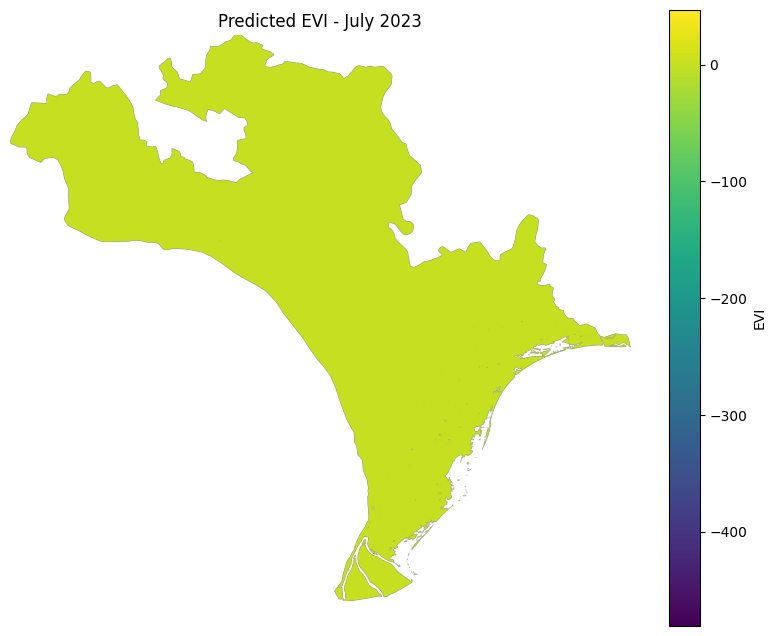

In [9]:
# STEP 6: Save prediction as GeoTIFF
print("Saving prediction to GeoTIFF...")#
# Use last image as template
with rasterio.open(os.path.join(folder, files[-1])) as src:
    profile = src.profile
    profile.update(dtype=rasterio.float32, count=1)
    with rasterio.open("/content/drive/MyDrive/predicted_evi_july_2023.tif", "w", **profile) as dst:
        dst.write(predicted.astype(np.float32), 1)#
print("Prediction saved as: predicted_evi_july_2023.tif")#
# STEP 7: Preview the prediction
plt.figure(figsize=(10, 8))
plt.imshow(predicted, cmap='viridis')
plt.colorbar(label='EVI')
plt.title("Predicted EVI - July 2023")
plt.axis('off')
plt.savefig("/content/drive/MyDrive/predicted_evi_july_2023.png", dpi=300)
plt.show()